In [ ]:
#### Create Plots based on OSCAR xml files ####
# analysis of specific variables

# used python version 3.10.6

In [1]:
import xml.etree.ElementTree as ET
import urllib.request
import csv
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import json
import re
import os
import pandas as pd

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import matplotlib.lines as mlines
from urllib.request import urlopen
from functools import reduce
from datetime import date

In [46]:
country = "KEN"
variable = "224"

In [2]:
# define function: get all WIGOS identifier

def get_WIGOS_ID_country(country):

    """ use the OSCAR API to find all stations registered within one country

    Parameters:
        country (str): country code - e.g. KEN for Kenya

    Returns:
        wigosIds (list): list of all WIGOS IDs of registered stations in selected country
    """

    # open API
    all_stations_KEN_url = "https://oscar.wmo.int/surface/rest/api/search/station?territoryName=" + country
    response = urlopen(all_stations_KEN_url)
    data_json = json.loads(response.read())

    # find WIGOS IDs and save in list
    wigosIds = []
    for station in data_json["stationSearchResults"]:
        wigosId = str(station["wigosId"])
        wigosIds.append(wigosId)

    return wigosIds



In [3]:
# define function: get xml files

def get_xml_info(WIGOS_ID):

    """get xml information through jOAI and save file

        Parameters:
        WIGOS_ID (str): WIGOS identifier of the station of interest
    """

    # open xml file through jOAI
    url = "https://oscar.wmo.int/oai/provider?verb=GetRecord&metadataPrefix=wmdr&identifier=%20" + str(id)
    xml = urlopen(url).read()
    soup = BeautifulSoup(xml, 'xml')
    content = soup('OAI-PMH')

    # save file
    with open(os.getcwd()+"/Files/File_"+id+".txt", 'w') as f:
        f.write(str(content))

In [7]:
# define function: find all deployments of a variable of interest in a country

def get_deployments_variable_country(country, variable):

    """ find all deployments of a variable of interest in a country

        Parameters:
        country (str): country of interest, e.g. "KEN"
        variable (str): notation of variable according to WMDR (e.g. 224 for Air temperature)

        Returns:
        df_variable: data frame including all deployments of all stations measuring the variable in the country
    """    

    # prepare data frame 
    df_variable = pd.DataFrame(np.nan, index=[0],columns=["beginPosition", "endPosition", "station", "variable"])

    # get WIGOS IDs
    wigosIds = get_WIGOS_ID_country(country)

    for id in wigosIds:
        print(id)

        # open xml
        observedProperties = []
        url = "https://oscar.wmo.int/oai/provider?verb=GetRecord&metadataPrefix=wmdr&identifier=%20" + id
        xml = urlopen(url).read()
        soup = BeautifulSoup(xml, 'xml')

        # find observed properties
        with open(os.getcwd()+"/Files/File_"+id+".txt") as myFile:
            observedProperties_line = soup.find_all('observedProperty')
            observedProperties_notation = re.findall(r'\d+',str(observedProperties_line))
            observedProperties.append(observedProperties_notation)
        
        # check if variable of interest is measured at the station
        if str(variable) in observedProperties[0]:
            station = id
            # find line numbers containing the WMDR number of the observed property
            numbers = []

            with open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt') as myFile:
                for num, line in enumerate(myFile, 1):
                    if variable in line:
                        numbers.append(num)

            # find the line numbers with <om:observedProperty
            obs = "observedProperty"
            numbers_obs = []
            # get line numbers containing variable
            f=open(os.getcwd()+"/Files/File_"+id+".txt")
            lines=f.readlines()
            for n in numbers:
                if obs in lines[n-1]:
                    number = re.findall(r'\d+',lines[n-1])
                    if number[0]==str(variable):
                        numbers_obs.append(n)

            # read 20 lines before "observedProperty" line to get "beginPosition" (& "endPosition")
            for n in numbers_obs:
                start = "beginPosition"
                end = "endPosition"
                line_numbers = range(n-50,n)

                f=open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt')
                lines=f.readlines()
                positions = []

                for n in line_numbers:
                    if start in lines[n]:
                        beginning = re.findall(r'\d{4}-\d{2}-\d{2}',lines[n])
                        if beginning:
                            pd.to_datetime(beginning, format='%Y-%m-%d')
                            positions.append(beginning[0])
                        else:
                            positions.append(np.nan)

                    elif end in lines[n]:
                        ending = re.findall(r'\d{4}-\d{2}-\d{2}',lines[n])
                        if ending:
                            pd.to_datetime(ending, format='%Y-%m-%d')
                            positions.append(ending[0])
                        else:
                            positions.append(pd.Timestamp.today().strftime("%Y-%m-%d"))

                beginPosition  = positions[0]
                endPosition = positions[1]
                # write information to data frame
                new_row = {"beginPosition":beginPosition,"endPosition":endPosition,"station":station,"variable":variable}
                df_variable.loc[len(df_variable)] = new_row

        # if variable not measured at station    
        else: 
            station = id
            new_row = {"beginPosition":np.nan,"endPosition":np.nan,"station":station,"variable":variable}
            df_variable.loc[len(df_variable)] = new_row


    df_variable.drop([0], axis=0, inplace=True)

    
    # get name of variable
    with open(os.getcwd()+'/WMDR_dictionaries/'+'T_GO_VARIABLE_REF_dictionary.json') as f:
        dictionary = json.loads(f.read())
    variables = df_variable["variable"]
    df_variable["variables_names"] = [(list(dictionary.keys())[list(dictionary.values()).index(str(vari))]) for vari in variables]


    return df_variable, wigosIds



In [9]:
# define function: create plot with overview of all deployments of a variable of interest within a country

def plot_deployments_variable_country(country, variable):

    """ create plot with overview of all deployments of a variable of interest within a country

        Parameters:
        country (str): country of interest, e.g. "KEN"
        variable (str): notation of variable according to WMDR (e.g. 224 for Air temperature)

    """    
    # plot
    plt.style.use('default')
    fig, axes = plt.subplots(1,1, figsize=(14,30))

    # get data frame with information to plot
    df_variable, wigosIds = get_deployments_variable_country(country, variable)

    # plot deployment for every station
    for id in range(0,len(wigosIds)):
        df_var = df_variable[df_variable["station"]==str(wigosIds[id])]
        plt.hlines(y=id, xmin=pd.Series(pd.to_datetime(df_variable["beginPosition"])).min(), xmax=pd.Timestamp.today(), linewidth=0.1, color="black")
        x_values = [pd.to_datetime(df_var["beginPosition"]), pd.to_datetime(df_var["endPosition"])]
        plt.plot(x_values, [id,id], 'bo', linestyle="--")

    # add station names
    names = []
    for var in range(0,len(wigosIds)):
        variable_df = df_variable[df_variable["station"]==str(wigosIds[var])]
        if not variable_df.empty:
            name = str(variable_df.iloc[0]["station"])
            names.append(name)

    plt.xlim(xmin= pd.Series((pd.to_datetime(df_variable["beginPosition"]))).min(), xmax=pd.Timestamp.today())
    n = range(0,len(names))
    plt.yticks(n,names)

    # title
    plt.title("Variable: " + variable, fontsize=16, fontweight="bold")

    # save plot to folder with today's date
    date_today = date.today()
    date_today.strftime("%m_%d_%Y")

    # check if directory exists, otherwise create
    dir = os.getcwd()+"/Plots/"+str(date_today)
    if not os.path.exists(dir):
        os.makedirs(dir)

    # save figure
    fig.savefig(dir+"/Deployments_"+variable+"_"+country+"_"+str(date_today)+"_.jpeg", bbox_inches='tight')

0-404-300-301570787AS00074
0-404-300-402261127AS63663
0-404-300-271440721AS00049
0-404-300-281480740AS00057
0-404-300-160800395AS00001
0-404-0-63707
0-404-300-392191090AS63662
0-404-0-63721
0-404-300-040200100AS00113
0-404-300-040200098AS00112
0-404-300-301620807AS00073
0-404-300-301580790AS00071
0-404-300-402251125AS00038
0-404-300-402281141AS00036
0-404-300-402291146AS00033
0-404-300-392181085AS63660
0-404-300-361950974AS00015
0-20000-0-63741
0-404-300-472781389AS63747
0-404-300-100470235AS00114
0-404-300-372081037AS00024
0-404-300-372000999AS00025
0-404-300-372031019AS00022
0-404-300-372101048AS00026
0-20000-0-63688
0-404-300-63686
0-20000-0-63720
0-404-0-63719
0-404-300-341870932AS00005
0-404-300-341840918A00001
0-404-300-050210101AS00090
0-404-0-63670
0-20000-0-63723
0-404-300-190950473AS00101
0-404-300-060230111AS00047
0-404-300-190950476AS00099
0-404-300-070320150AS00107
0-404-300-160810398AS0001
0-404-300-160810398AS00009
0-404-300-070320160AS00106
0-20000-0-63740
0-20000-0-636

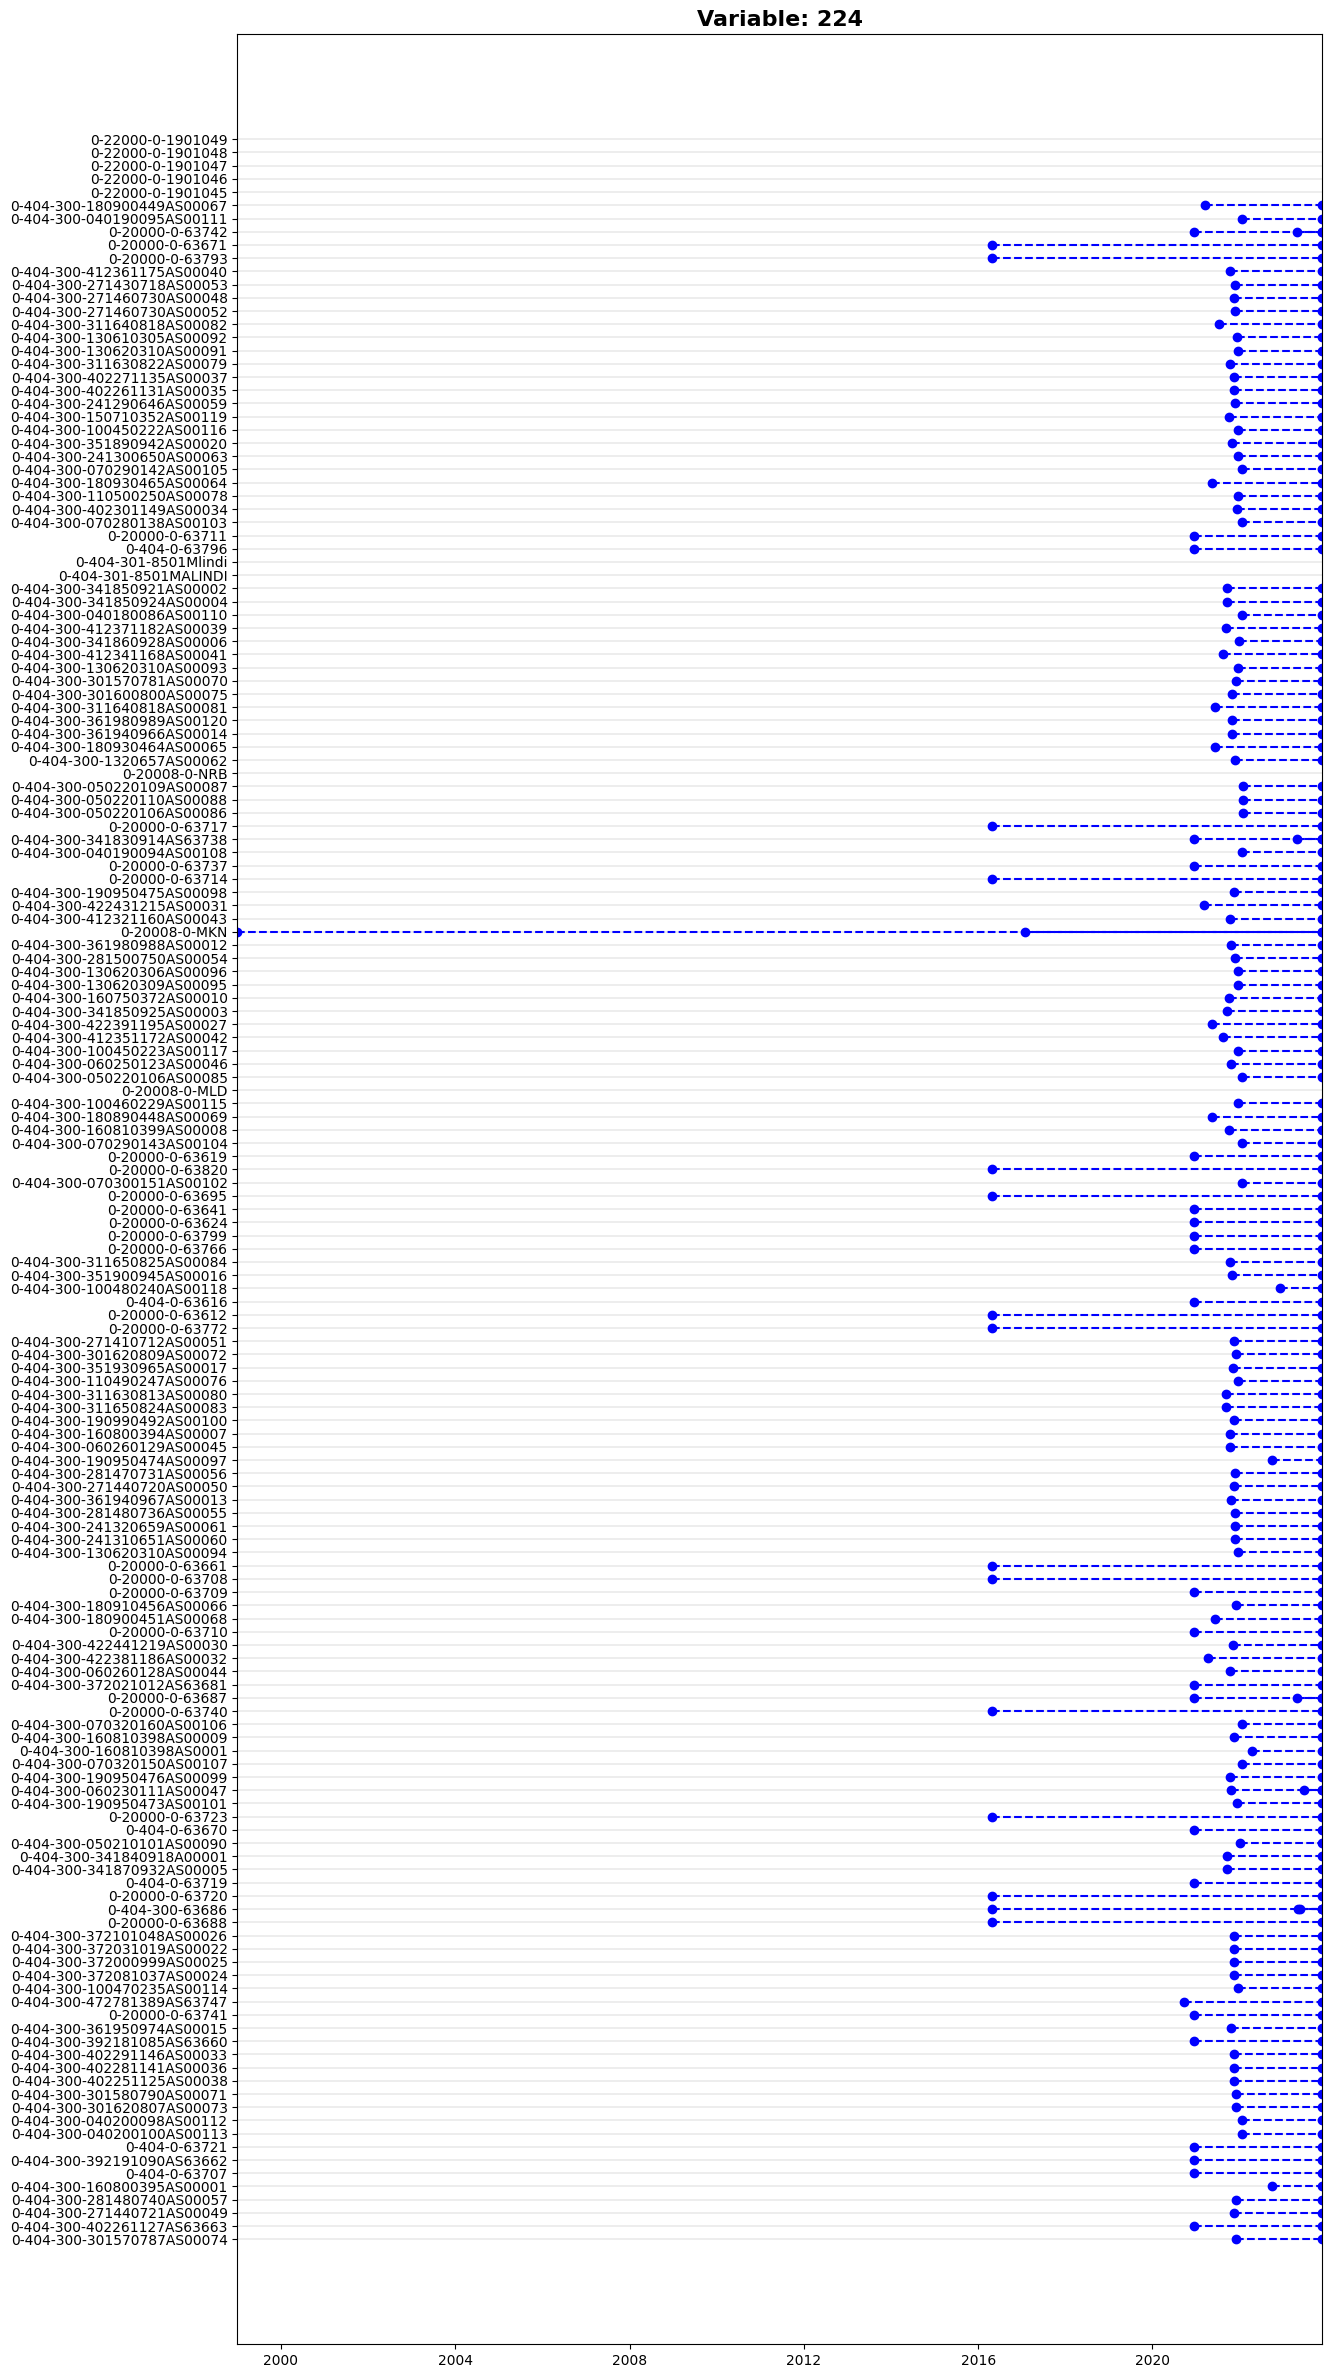

In [10]:
plot_deployments_variable_country(country="KEN", variable="224")